Model zum Erkennen abormaler Energie Nutzungen.

Imports

In [1]:
# Daten verarbeiten
import numpy as np
import pandas as pd

# Daten darstellen
import matplotlib.pyplot as plt
%matplotlib inline

# Weiteres
import os,random, math, psutil, pickle

Daten holen

In [4]:
for dirname, _, filenames in os.walk('./data/'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

./data/sample_submission.csv
./data/test.csv
./data/train_features.csv
./data/test_features.csv
./data/train.csv


In [8]:
root = './data/'

train_features = pd.read_csv(root+'train_features.csv')
test_features_df = pd.read_csv(root+'test_features.csv')

sample_submission = pd.read_csv(root + 'sample_submission.csv')

In [21]:
print('Size of train_features data', train_features.shape)
print('Size of test_features_df data', test_features_df.shape)

Size of train_features data (1749494, 57)
Size of test_features_df data (1800567, 57)


Benötigten Ram reduzieren da sonst ätzend damit zu arbeiten

In [29]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else: 
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64) 
                    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [22]:
train_features = reduce_mem_usage(train_features)
test_features_df = reduce_mem_usage(test_features_df)

Mem. usage decreased to 265.28 Mb (0.0% reduction)
Mem. usage decreased to 281.61 Mb (0.0% reduction)


In [23]:
train_features["timestamp"] = pd.to_datetime(train_features["timestamp"])
test_features_df["timestamp"] = pd.to_datetime(test_features_df["timestamp"])

In [24]:
train_features

,building_id,timestamp,meter_reading,anomaly,site_id,primary_use,square_feet,year_built,floor_count,air_temperature,...,gte_meter,gte_meter_hour,gte_meter_weekday,gte_meter_month,gte_meter_building_id,gte_meter_primary_use,gte_meter_site_id,gte_meter_building_id_hour,gte_meter_building_id_weekday,gte_meter_building_id_month
0,1,2016-01-01 00:00:00,NaN,0,0,Education,2720,104,0,19.40625,...,4.117188,3.980469,4.144531,4.121094,3.568359,4.488281,4.078125,3.554688,3.537109,3.845703
1,32,2016-01-01 00:00:00,NaN,0,0,Office,48392,105,0,19.40625,...,4.117188,3.980469,4.144531,4.121094,4.511719,4.210938,4.078125,4.128906,4.578125,4.316406
2,41,2016-01-01 00:00:00,NaN,0,0,Office,93860,68,0,19.40625,...,4.117188,3.980469,4.144531,4.121094,4.109375,4.210938,4.078125,4.101562,4.140625,4.113281
3,55,2016-01-01 00:00:00,NaN,0,0,Office,16726,111,0,19.40625,...,4.117188,3.980469,4.144531,4.121094,3.505859,4.210938,4.078125,3.308594,3.564453,3.812500
4,69,2016-01-01 00:00:00,NaN,0,0,Parking,387638,100,0,19.40625,...,4.117188,3.980469,4.144531,4.121094,3.035156,3.623047,4.078125,3.892578,3.089844,3.576172
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1749489,1316,2016-12-31 23:00:00,38.843750,0,14,Entertainment/public assembly,49975,255,0,-29.90625,...,4.117188,4.007812,4.011719,4.054688,3.910156,3.531250,4.710938,4.179688,3.802734,3.865234
1749490,1318,2016-12-31 23:00:00,202.875000,0,14,Entertainment/public assembly,73488,255,0,-29.90625,...,4.117188,4.007812,4.011719,4.054688,4.960938,3.531250,4.710938,4.964844,4.976562,5.316406
1749491,1319,2016-12-31 23:00:00,NaN,0,14,Entertainment/public assembly,287419,255,0,-29.90625,...,4.117188,4.007812,4.011719,4.054688,4.875000,3.531250,4.710938,4.882812,4.929688,4.906250
1749492,1323,2016-12-31 23:00:00,172.000000,0,14,Office,87200,255,0,-29.90625,...,4.117188,4.007812,4.011719,4.054688,5.210938,4.210938,4.710938,5.281250,5.160156,5.156250


In [27]:
print('Zeitraum: ', train_features.timestamp.min(), '—', train_features.timestamp.max())
print('Standorte: ', train_features.site_id.unique())

Zeitraum:  2016-01-01 00:00:00 — 2016-12-31 23:00:00
Standorte:  [ 0  1  2  3  4  5  7  8  9 10 12 13 14 15]


Fehlende Werte bzw Null werte

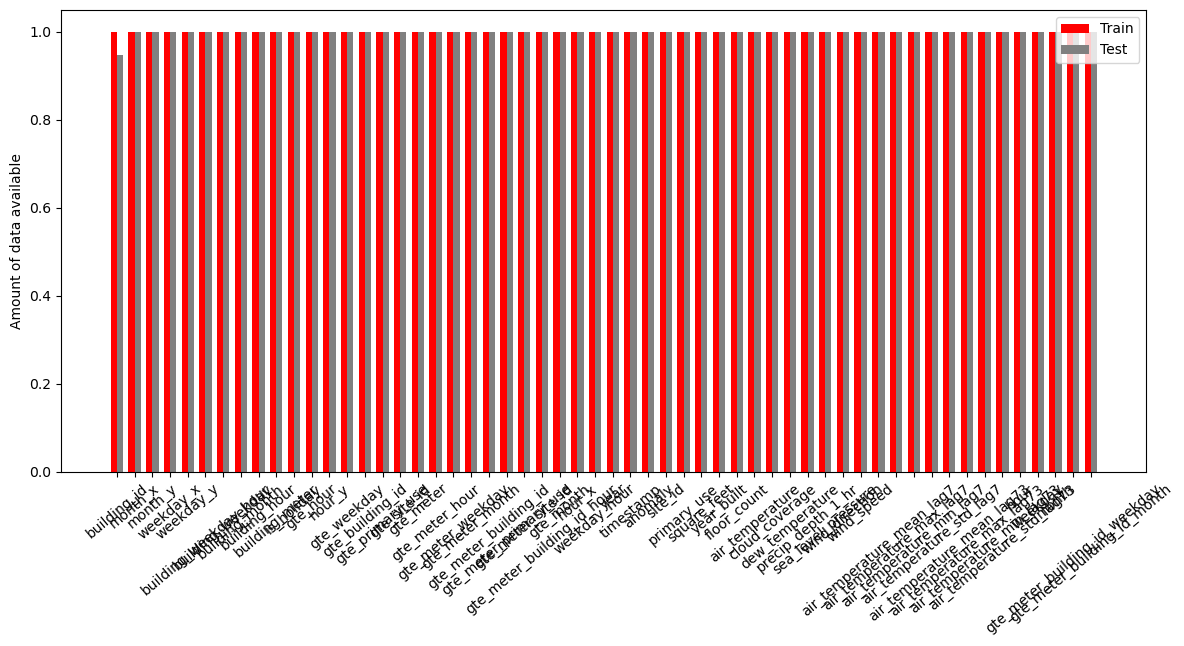

In [34]:
train_data = (train_features.count() / len(train_features)).drop('meter_reading').sort_values().values
ind = np.arange(len(train_data))
width = 0.35

fig, axes = plt.subplots(1,1,figsize=(14, 6), dpi=100)
tr = axes.bar(ind, train_data, width, color='red')

test_data = (test_features_df.count() / len(test_features_df)).drop('row_id').sort_values().values
tt = axes.bar(ind+width, test_data, width, color='grey')

axes.set_ylabel('Amount of data available');
axes.set_xticks(ind + width / 2)
axes.set_xticklabels((train_features.count() / len(train_features)).drop('meter_reading').sort_values().index, rotation=40)
axes.legend([tr, tt], ['Train', 'Test']);